In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import collections
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.image as mpimg
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
import gc

# Plot Comparison of the Statistics of different Descriptor Evaluation 

In [17]:
#####################
### PLOT FUNCTIONS
#####################
def draw_square_mm(
    ax,
    data_value:np.array,
    data_color:np.array,
    cmap:mpl.colors.LinearSegmentedColormap,
    colorbar_labels:List[str],
    spines_visibility:Tuple[bool, bool, bool, bool]=[False, False, False, False],
    tickparams:Dict={'axis':'both', 'which':'both', 'bottom':False, 'left':False},
    xticklabels:List=[],
    yticklabels:List=[],
    xlabel:str='',
    ylabel:str='',
    title:str='',
    textcolor:str='black'):
    """Draw square containing used matching method for a descriptor/
    detector combination together with colorbar."""
    
    # Remove ticks, but not labels
    ax.tick_params(**tickparams)
    
    # TickLabels
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    
    # X/Y Labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(title)
    
    # Spines
    ax.spines['top'].set_visible(spines_visibility[0])
    ax.spines['right'].set_visible(spines_visibility[1])
    ax.spines['bottom'].set_visible(spines_visibility[2])
    ax.spines['left'].set_visible(spines_visibility[3])

    # For correct placements of labels of colorbar
    bounds = np.linspace(0.5, len(evaluations) + 1.5, len(evaluations)+2)
    norm = mpl.colors.BoundaryNorm(bounds, cmap_mm.N)

    # Show map of indices of matching methods with best scores
    handle = ax.imshow(data_color, cmap=cmap, norm=norm)

    # insert values as text
    for i in range(data_value.shape[0]):
        for j in range(data_value.shape[1]):
            val = data_value[i][j]
            if not np.isnan(val):
                # Write the best matching method, else ignore
                ax.text(j, i, '\n{:.1f}'.format(val * 100), color='white',
                       horizontalalignment='center',
                       verticalalignment='center')  


    # Create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.0.5 inches.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    # Add colorbar
    cbar = fig.colorbar(handle, cax=cax, ticks=bounds-0.5)
    cbar.ax.set_yticklabels(colorbar_labels)
    cbar.ax.tick_params(right=False)
    
    return ax

def draw_square(
    ax,
    data:np.array,
    cmap:mpl.colors.LinearSegmentedColormap,
    spines_visibility:Tuple[bool, bool, bool, bool]=[False, False, False, False],
    tickparams:Dict={'axis':'both', 'which':'both', 'bottom':False, 'left':False},
    xticklabels:List=[],
    yticklabels:List=[],
    xlabel:str='',
    ylabel:str='',
    title:str='',
    textcolor:str='black'):
    """Draw red to green sqares for goodness of a descriptor/detector
    combination."""

    # set tick params
    ax.tick_params(**tickparams)

    ax.spines['top'].set_visible(spines_visibility[0])
    ax.spines['right'].set_visible(spines_visibility[1])
    ax.spines['bottom'].set_visible(spines_visibility[2])
    ax.spines['left'].set_visible(spines_visibility[3])

    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_title(title)

    _vals = data[~np.isnan(data)]
    ax.imshow(data, cmap=cmap, vmin=np.min(_vals), vmax=np.max(_vals))

    # Loop over data to dimensions and create text annotations.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):

            _data = data * 100
            t = '' if np.isnan(_data[i, j]) else '{:.1f}'.format(_data[i, j])
            text = ax.text(j, i, 
                           t, 
                           ha='center', 
                           va='center', 
                           color=textcolor);

#####################
### FUNCTIONS
#####################
def find_best_matching_method_by_avg_score(
    evaluations:List[str],
    eval_dict:Dict,
    desc2row:Dict,
    det2col:Dict,
    filters:Dict={}) -> Tuple[np.array, np.array, np.array]:
    """Returns labels and avg score for each matching method in
    descending order as well as their sorting indices."""
    scoremaps = []
    labels = []
    for evaluation in evaluations:
        df = get_dataframe(evaluation, eval_dict)

        scoremaps.append(create_scoremap(df, desc2row, det2col, filters=filters))
        labels.append(eval_dict[evaluation]['label'])

    # Convert to np.array
    scoremaps = np.array(scoremaps)
    labels = np.array(labels)

    # Build average score for an evaluation
    avg_scores = np.array([np.nanmean(x) for x in scoremaps])

    # sort by avg_scores
    idx_descending = avg_scores.argsort()[::-1]
    avg_scores = avg_scores[idx_descending]
    labels = labels[idx_descending]
    
    return labels, avg_scores, idx_descending

def get_dataframe(evaluation_method:str, eval_dict:Dict) -> pd.DataFrame:
    file_name = eval_dict[evaluation_method]['file_name'] + '.csv'
    
    # Load data
    df = pd.read_csv(os.path.join(data_dir, file_name), sep=',', comment='#')
    
    return df

def create_scoremap(
    df:pd.DataFrame,
    desc2row:Dict,
    det2col:Dict,
    filters:Dict={}) -> np.array:
    """Creates a single scoremap for ALL triplets 
    (kp_thresh, descriptor_name, detector_name)"""
    scoremap = np.full((len(descriptor_names), len(detector_names)), np.nan)
    
    # Filter df for each key-value pair in filters
    _df = df
    for k, v in filters.items():
        _df = _df[df[k] == v]

    # Group by descriptors and detectors
    _g = _df.groupby(['descriptor_name', 'detector_name'])


    for gname, group in _g:
        i = desc2row[gname[0]]
        j = det2col[gname[1]]

        values = group[['matchability', 'accuracy_matches', 'inlier_ratio', 'accuracy_inliers']]
        
        # Build mean for each column
        mean_values = np.mean(values, axis=0)

        # Build mean of means to get score
        score = np.mean(mean_values)

        scoremap[i][j] = score
    
    return scoremap


def save_figure(
  path_output:str,
  fig_name:str, 
  figure: mpl.figure.Figure,
  dpi:int=300,
  tight_layout:bool=False) -> None:

    if not os.path.exists(path_output):
        os.makedirs(path_output, exist_ok=True)

    f_out = os.path.join(path_output, fig_name)
  
    if tight_layout:
        figure.savefig(f_out, bbox_inches='tight', pad_inches=0, dpi=dpi)
    else:
        figure.savefig(f_out, dpi=dpi)


#####################
### SETTINGS
#####################
desc2row = {
    'doap': 0,
    'lift': 1,
    'sift': 2,
    'superpoint': 3,
    'tfeat': 4
}

det2col = {
    'lift': 0,
    'sift': 1,
    'superpoint': 2,
    'tcovdet': 3,
    'tilde': 4
}


id2name = {
    'sift': 'SIFT',
    'lift': 'LIFT',
    'tilde': 'TILDE',
    'superpoint': 'SuperPoint',
    'tcovdet': 'TCovDet',
    'tfeat': 'TFeat',
    'doap': 'DOAP',
    'v_set_01': 'Set 1',
    'v_set_02': 'Set 2',
    'v_set_03': 'Set 3',
    'v_set_04': 'Set 4',
    'v_set_05': 'Set 5',
    'v_set_06': 'Set 6',
    'v_set_07': 'Set 7',
    'v_set_08': 'Set 8',
    'v_set_09': 'Set 9',
    'v_set_10': 'Set 10',
    'v_set_11': 'Set 11',
    'v_set_12': 'Set 12',
    'v_set_13': 'Set 13'
}

color_scheme = {
  'sift': '#1f77b4',
  'lift': '#ff7f0e',
  'tilde': '#2ca02c',
  'superpoint': '#d62728',
  'tcovdet': '#9467bd',
  'tfeat': '#2ca02c',
  'doap': '#9467bd'
}

keypoint_threshold_colors = ['skyblue', 'purple', 'crimson']

marker_scheme = {
  'sift': 'o',
  'lift': 'x',
  'tilde': 'd',
  'superpoint': '^',
  'tcovdet': 'h',
  'tfeat': '*',
  'doap': 'p'
}

line_styles = ['-', '-.', ':', '--']

data_dir = '/home/mizzade/Workspace/diplom/outputs/eval_matching_pipeline'
output_dir_root = '/home/mizzade/Workspace/diplom/outputs/eval_matching_pipeline/plots'

eval_dict = {
    'nn2way': {
        'file_name': 'descriptor_matching_eisert_nn2way',
        'label': 'NN2WAY'
    },
    'bf_ratio': {
        'file_name': 'descriptor_matching_eisert_bf_ratio',
        'label': 'BF + Ratio'
    },
    'bf': {
        'file_name': 'descriptor_matching_eisert_bf',
        'label': 'BF'
    },
    'flann': {
        'file_name': 'descriptor_matching_eisert_flann',
        'label': 'FLANN'
    },
    'flann_ratio': {
        'file_name': 'descriptor_matching_eisert_flann_ratio',
        'label': 'FLANN + Ratio'
    },
    'nn2way_no_normalization': {
        'file_name': 'descriptor_matching_eisert_nn2way_no_normalization',
        'label': 'NN2WAY\n(no normalization)'
    },
    'bf_ratio_no_normalization': {
        'file_name': 'descriptor_matching_eisert_bf_ratio_no_normalization',
        'label': 'BF + Ratio\n(no normalization)'
    },
    'bf_no_normalization': {
        'file_name': 'descriptor_matching_eisert_bf_no_normalization',
        'label': 'BF\n(no normalization)'
    },
    'flann_no_normalization': {
        'file_name': 'descriptor_matching_eisert_flann_no_normalization',
        'label': 'FLANN\n(no normalization)'
    },
    'flann_ratio_no_normalization': {
        'file_name': 'descriptor_matching_eisert_flann_ratio_no_normalization',
        'label': 'FLANN + Ratio\n(no normalization)'
    },
}


# nn2way | bf | bf_ratio | flann | flann_ratio | nn2way_no_normalization | bf_no_normalization | 
# bf_ratio_no_normalization | flann_no_normalization | flann_ratio_no_normalization

evaluations = ['nn2way', 'bf', 'bf_ratio', 'flann', 'flann_ratio', 'nn2way_no_normalization', 
               'bf_no_normalization',  'bf_ratio_no_normalization', 'flann_no_normalization', 
               'flann_ratio_no_normalization']

# CUSTOM COLORS for matching methods and "goodness"
# Create color palette for matching methods with and without normlization
# Combine colors. White is for NaN values
colors_mm_with_normalization = plt.style.library['seaborn']['axes.prop_cycle'].by_key()['color'][:5]
colors_mm_without_normalization =  plt.style.library['fivethirtyeight']['axes.prop_cycle'].by_key()['color'][:5]
colors_mm = np.array(colors_mm_with_normalization + colors_mm_without_normalization  + ['white'])

# Create linear custom cmap from colors_mm for matching methods
cmap_mm = mpl.colors.LinearSegmentedColormap.from_list("", colors_mm, len(evaluations)+1)

# Create linear colormap for "goodness"
cmap_good = mpl.colors.LinearSegmentedColormap.from_list("", ['tomato', 'gold', 'forestgreen'], 10)

# Labels for for color bars depicting matching strategies.
colorbar_labels_mm = [eval_dict[x]['label'] for x in evaluations] + ['Keine Messung']



# TODO : OUTPUT DIR

#####################
### MAIN
#####################
for evaluation in evaluations[:1]:
    
    # Load data
    df = get_dataframe(evaluation, eval_dict)

    descriptor_names = sorted(df.descriptor_name.unique())
    detector_names = sorted(df.detector_name.unique())
    set_names = sorted(df.set_name.unique())
    desc_distance_thresholds = sorted(df.desc_distance_threshold.unique())
    kpts_thresholds = sorted(df.kpts_threshold.unique())

    desc_dist = desc_distance_thresholds[0]
    kp_thresh = kpts_thresholds[0]
    
    labels_detector = [''] + [id2name[x] for x in detector_names]
    labels_descriptor = [''] + [id2name[x] for x in descriptor_names]

Finde das Verfahren mit den im Durchschnitt besten Werten für alle Detektor-Deskriptor Kombinationen

In [3]:
df.columns

Index(['collection_name', 'set_name', 'kpts_threshold', 'descriptor_name',
       'detector_name', 'matching_method', 'desc_distance_threshold',
       'ransac_threshold', 'ransac_confidence', 'num_kpts_i', 'num_kpts_j',
       'max_num_matches', 'num_matches', 'matchability', 'accuracy_matches',
       'mse_matching', 'max_num_inliers', 'num_inliers', 'inlier_ratio',
       'avg_distance', 'mse_estimation', 'accuracy_inliers'],
      dtype='object')

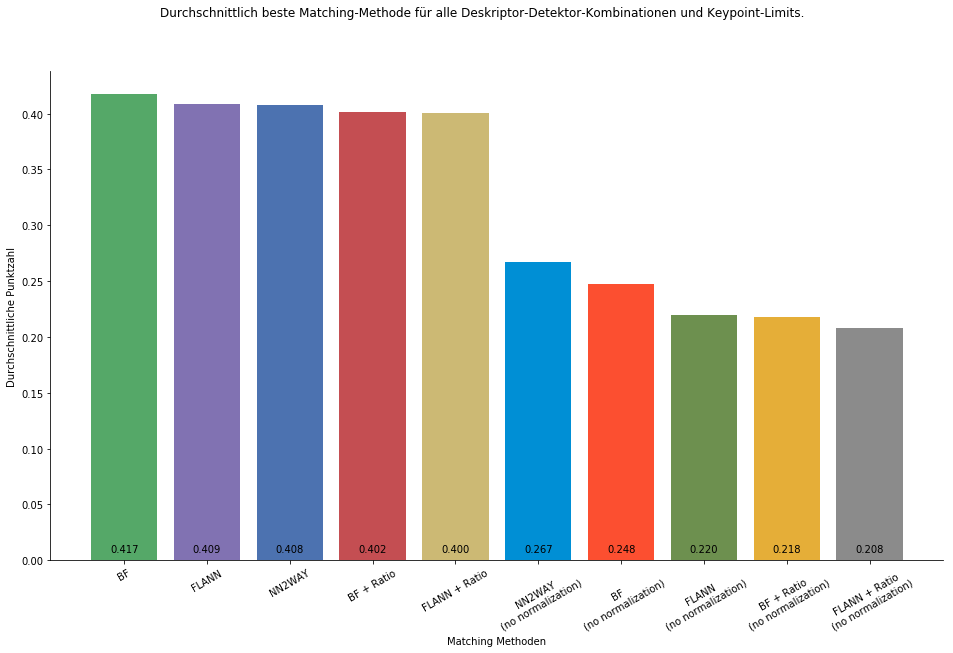

In [10]:
# 1. Welches Verfahren ist durchschnittlich das Beste?
labels, scores, idx = find_best_matching_method_by_avg_score(evaluations, eval_dict, desc2row, det2col)

_colors = colors_mm[idx]

# Plot bar chart
plt.rcParams['figure.figsize'] = [16,9]
fig, ax = plt.subplots(1, 1)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set labels
ax.set_xlabel('Matching Methoden')
ax.set_ylabel('Durchschnittliche Punktzahl')

# Rotate x-ticklabels
ax.tick_params(axis='x', which='both', labelrotation=30) 


ax.bar(labels, scores, color=_colors)

# print values in bars
for label, score in zip(labels, scores):
    ax.text(label, 0.01, '{:.3f}'.format(score), color='black', horizontalalignment='center', verticalalignment='center')

fig.suptitle('Durchschnittlich beste Matching-Methode für alle Deskriptor-Detektor-Kombinationen und Keypoint-Limits.');

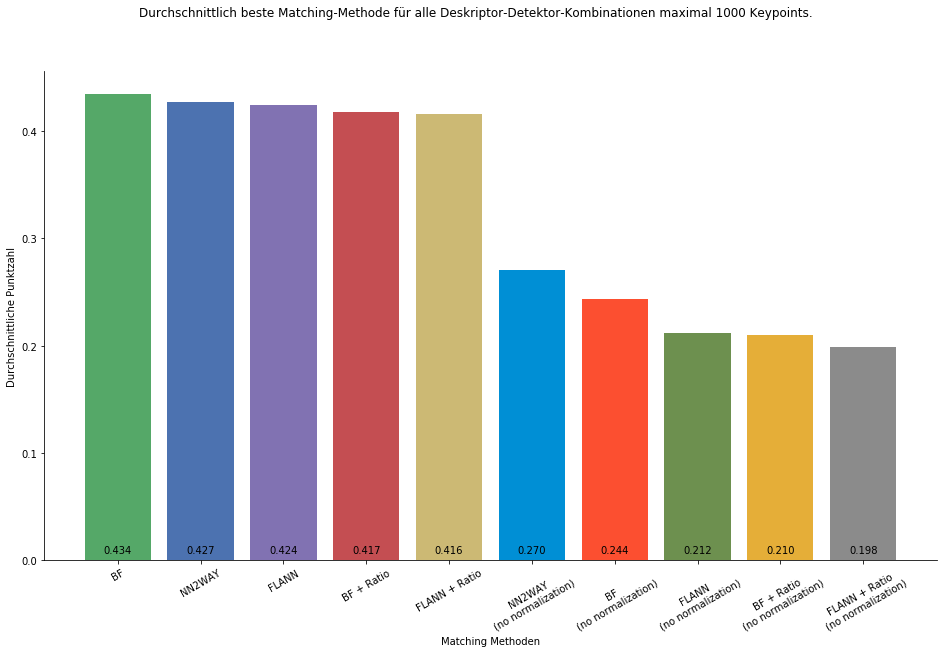

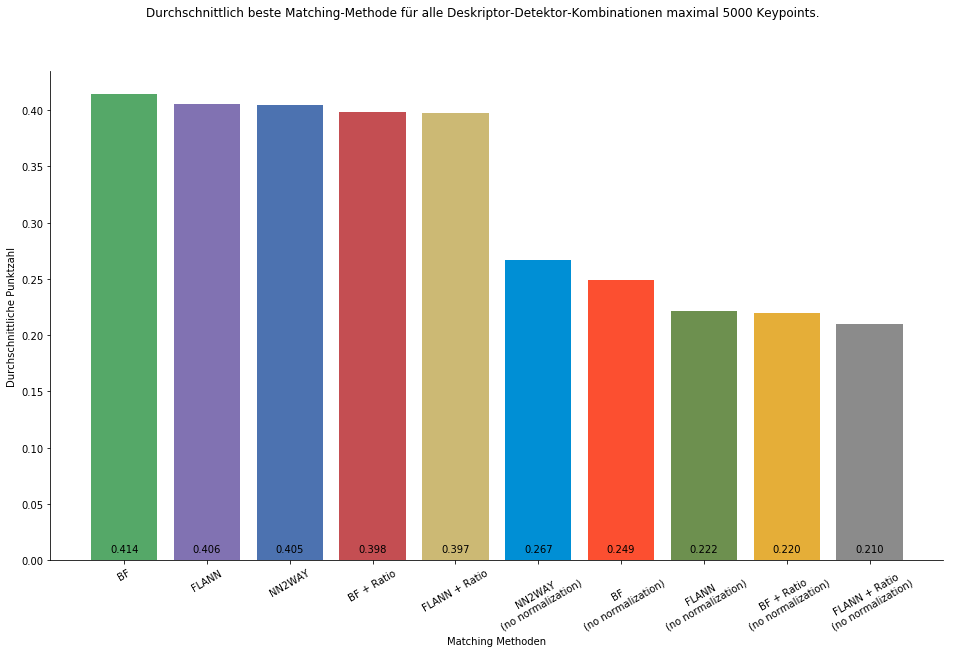

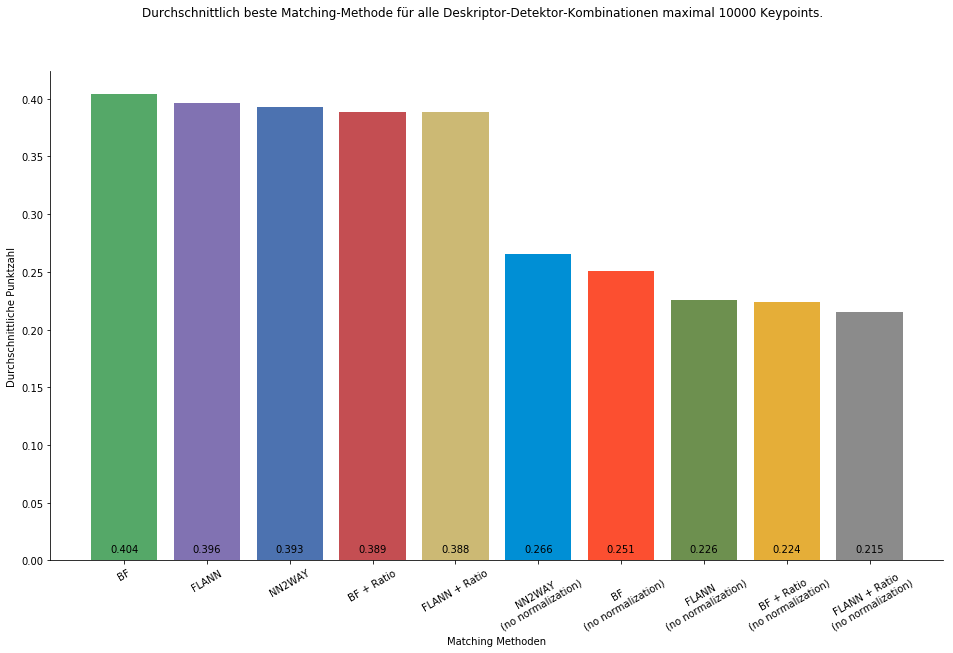

In [5]:
# Wie sieht es bei bei anderen keypoint thresholds aus?
# 1. Welches Verfahren ist durchschnittlich das Beste?

for kp_thresh in kpts_thresholds:
    labels, scores, idx = find_best_matching_method_by_avg_score(
        evaluations, 
        eval_dict, 
        desc2row, 
        det2col,
        filters={'kpts_threshold': kp_thresh})
    
    _colors = colors_mm[idx]

    # Plot bar chart
    plt.rcParams['figure.figsize'] = [16,9]
    fig, ax = plt.subplots(1, 1)

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set labels
    ax.set_xlabel('Matching Methoden')
    ax.set_ylabel('Durchschnittliche Punktzahl')

    # Rotate x-ticklabels
    ax.tick_params(axis='x', which='both', labelrotation=30) 


    ax.bar(labels, scores, color=_colors)

    # print values in bars
    for label, score in zip(labels, scores):
        ax.text(label, 0.01, '{:.3f}'.format(score), color='black', horizontalalignment='center', verticalalignment='center')

    fig.suptitle('Durchschnittlich beste Matching-Methode für alle Deskriptor-Detektor-Kombinationen maximal {} Keypoints.'.format(kp_thresh));

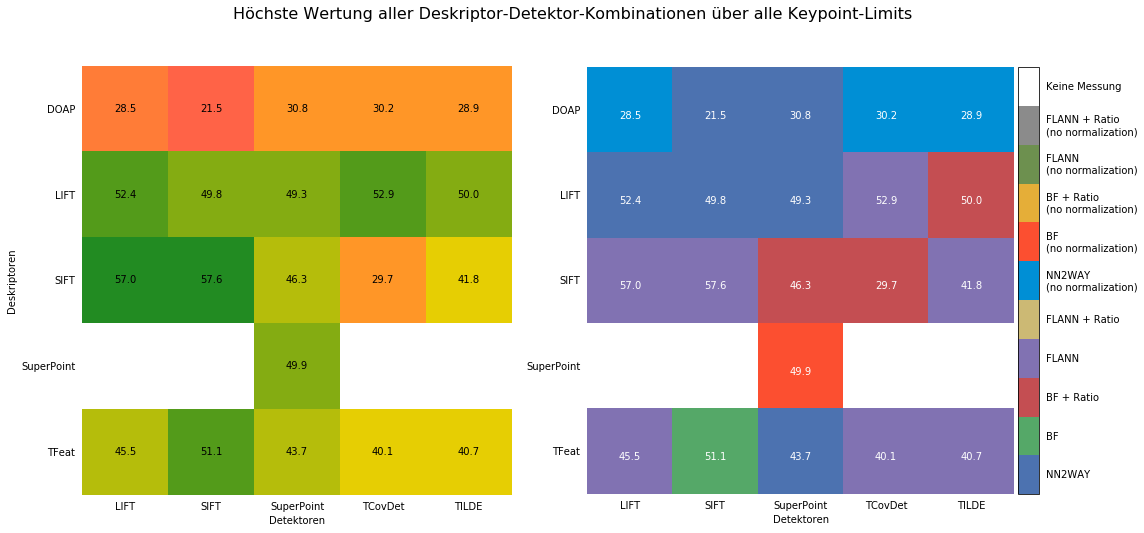

In [19]:
# In Anbetracht, dass BF, FLANN und NN2WAY sehr nahe beieinander liegen, sollte überprüft werden, für welches
# Verfahren für welche Kombination von Deskriptor und Detektor am besten ist.

# Get scoremap for each evaluation method
scoremaps = []
labels = []
for evaluation in evaluations:
    df = get_dataframe(evaluation, eval_dict)

    scoremaps.append(create_scoremap(df, desc2row, det2col))
    labels.append(eval_dict[evaluation]['label'])

scoremaps = np.array(scoremaps)
labels = np.array(labels)

# Find the index of the matching method with hightest score
# best_mm = best matching method
idx_best_mm = np.argmax(scoremaps, axis=0)

data_value = np.zeros_like(idx_best_mm, dtype=np.float)
data_color = np.zeros_like(idx_best_mm, dtype=np.int)

for i in range(idx_best_mm.shape[0]):
    for j in range(idx_best_mm.shape[1]):
        # Best index of scoremaps:
        idx = idx_best_mm[i][j]
        
        # Value inside corresponding scoremap:
        val = scoremaps[idx][i][j]
        
        data_value[i][j] = val
        data_color[i][j] = idx
        
        if np.isnan(val):
            data_color[i][j] = len(evaluations) + 1 # White
            
            
# Plot the data
plt.rcParams['figure.figsize'] = [16, 9]
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [.95, 1]})

ax = axes[0]
draw_square(ax, data_value, cmap_good,
            xticklabels=labels_detector,
            yticklabels=labels_descriptor,
            xlabel='Detektoren',
            ylabel='Deskriptoren')

ax = axes[1]
draw_square_mm(ax, data_value, data_color, cmap_mm, colorbar_labels_mm,
               xticklabels=labels_detector,
               yticklabels=labels_descriptor,
               xlabel='Detektoren',)

fig.suptitle('Höchste Wertung aller Deskriptor-Detektor-Kombinationen über alle Keypoint-Limits', fontsize=16);
fig.tight_layout()
fig.subplots_adjust(top=1.1)

Wie sieht es bei einzelnen Keypoint-Limits aus?

In [7]:
create_scoremap?

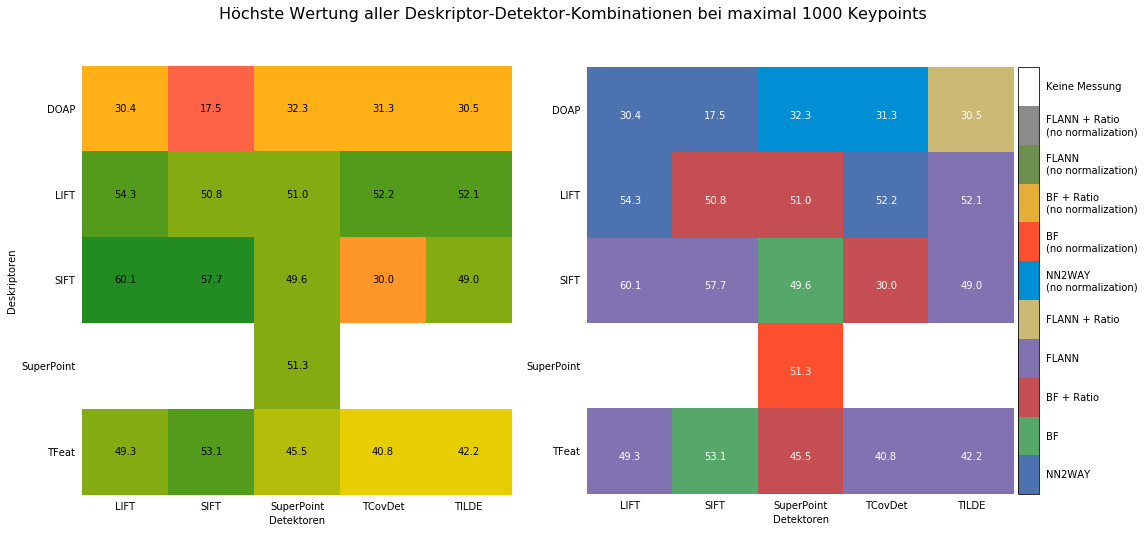

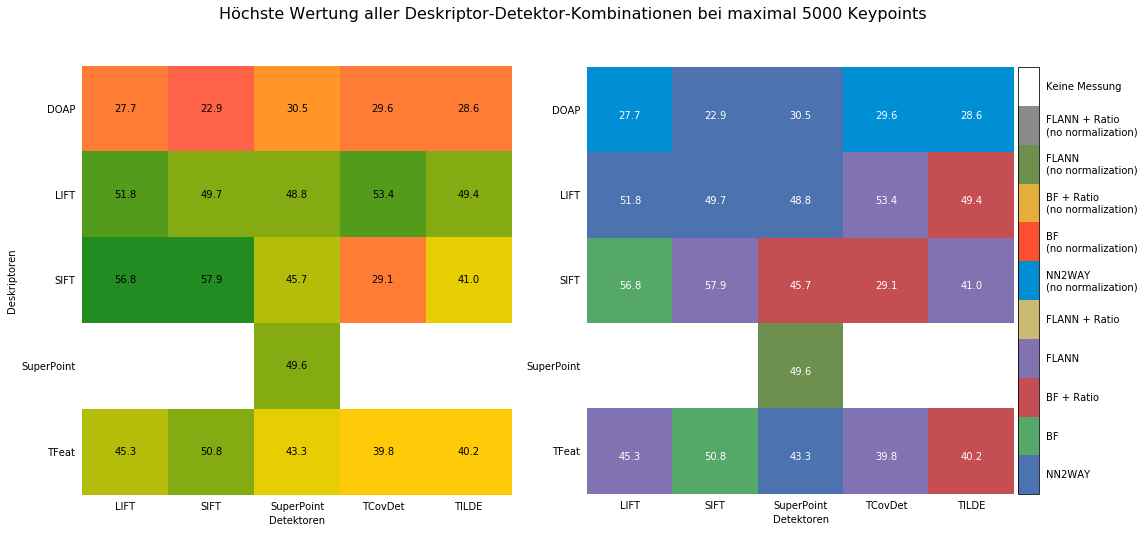

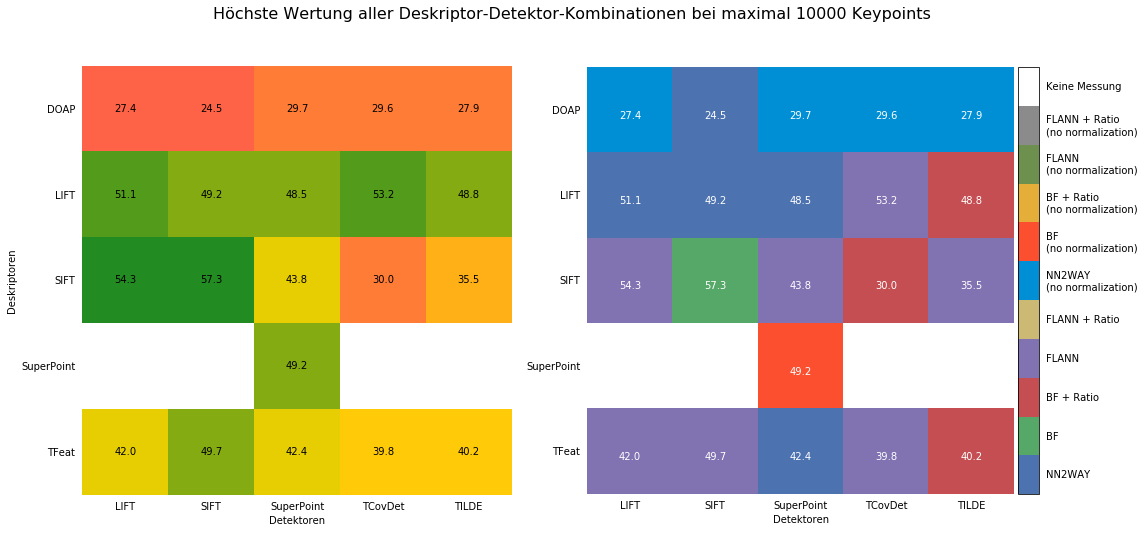

In [20]:
for kp_thresh in kpts_thresholds:
    # Get scoremap for each evaluation method
    scoremaps = []
    labels = []
    for evaluation in evaluations:
        df = get_dataframe(evaluation, eval_dict)

        scoremaps.append(create_scoremap(df, desc2row, det2col, {'kpts_threshold': kp_thresh}))
        labels.append(eval_dict[evaluation]['label'])

    scoremaps = np.array(scoremaps)
    labels = np.array(labels)

    # Find the index of the matching method with hightest score
    # best_mm = best matching method
    idx_best_mm = np.argmax(scoremaps, axis=0)

    data_value = np.zeros_like(idx_best_mm, dtype=np.float)
    data_color = np.zeros_like(idx_best_mm, dtype=np.int)

    for i in range(idx_best_mm.shape[0]):
        for j in range(idx_best_mm.shape[1]):
            # Best index of scoremaps:
            idx = idx_best_mm[i][j]

            # Value inside corresponding scoremap:
            val = scoremaps[idx][i][j]

            data_value[i][j] = val
            data_color[i][j] = idx

            if np.isnan(val):
                data_color[i][j] = len(evaluations) + 1 # White


    # Plot the data
    plt.rcParams['figure.figsize'] = [16, 9]
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [.95, 1]})

    ax = axes[0]
    draw_square(ax, data_value, cmap_good, 
                xticklabels=labels_detector,
               yticklabels=labels_descriptor,
               xlabel='Detektoren',
               ylabel='Deskriptoren')

    ax = axes[1]
    draw_square_mm(ax, data_value, data_color, cmap_mm, colorbar_labels_mm,
                   xticklabels=labels_detector,
                   yticklabels=labels_descriptor,
                   xlabel='Detektoren')

    fig.suptitle('Höchste Wertung aller Deskriptor-Detektor-Kombinationen bei maximal {} Keypoints'.format(kp_thresh), fontsize=16);
    fig.tight_layout()
    fig.subplots_adjust(top=1.1)